In [72]:
import torch
import shap
import pickle
import os
import traceback

import torch.nn as nn
import polars as pl
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from tqdm import tqdm
from time import time
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [150]:
df_all = pl.read_csv('features.csv')
df_all.columns, df_all.shape


(['flesch_reading_ease',
  'flesch_kincaid_grade',
  'gunning_fog',
  'smog_index',
  'automated_readability_index',
  'coleman_liau_index',
  'linsear_write_formula',
  'dale_chall_readability_score',
  'difficult_words',
  'sentence_count',
  'syllable_count',
  'lexicon_count',
  'char_count',
  'letter_count',
  'polysyllabcount',
  'monosyllabcount',
  'reading_time',
  'text_standard',
  'spache_readability',
  'mcalpine_eflaw',
  'LABEL'],
 (85450, 21))

Find weak learners

In [ ]:
df_weak_0 = df_all.filter(pl.col('LABEL') == -1)
df_weak_1 = df_all.filter(pl.col('LABEL') == 1)
for col in df_all.columns:
    mean_0 = df_weak_0[col].mean()
    mean_1 = df_weak_1[col].mean()
    median_0 = df_weak_0[col].median()
    median_1 = df_weak_1[col].median()
    print(f'\n{col} : {mean_0:.3f}, {mean_1:.3f}\n'{median_0:.3f}, {median_1:.3f})

## 1. XGB

### All features (except count related features)

In [151]:
count_features = [
    'difficult_words',
    'sentence_count',
    'syllable_count',
    'lexicon_count',
    'char_count',
    'letter_count',
    'polysyllabcount',
    'monosyllabcount'
]

In [152]:
X_all = df_all.drop(['LABEL'] + count_features).to_numpy()
y_all = df_all['LABEL'].apply(lambda y: 0 if y == -1 else 1).to_numpy()
X_all.shape, y_all.shape

((85450, 12), (85450,))

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=447128, shuffle=True, stratify=y_all)

Train Report
--------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.950     0.949     0.950     46837
           1      0.890     0.892     0.891     21523

    accuracy                          0.931     68360
   macro avg      0.920     0.921     0.921     68360
weighted avg      0.931     0.931     0.931     68360

Test Report
--------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.921     0.919     0.920     11709
           1      0.825     0.827     0.826      5381

    accuracy                          0.890     17090
   macro avg      0.873     0.873     0.873     17090
weighted avg      0.890     0.890     0.890     17090



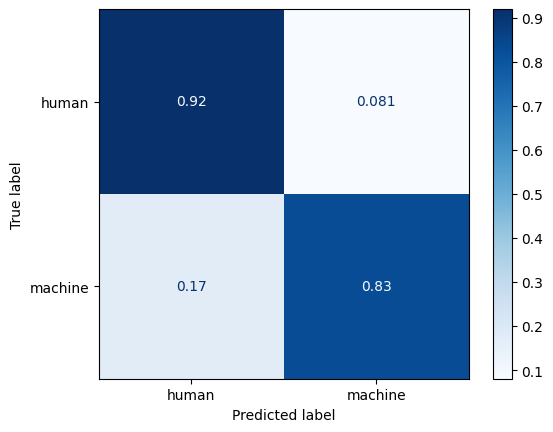

In [154]:
xgb_model = xgb.XGBRegressor(objective="binary:logistic")
xgb_model.fit(X_train, y_train)

pred_values = xgb_model.predict(X_train)
pred_labels = np.round(pred_values)
print('Train Report')
print('--------------------------------------------------------------')
print(classification_report(y_train, pred_labels, digits=3))

pred_values = xgb_model.predict(X_test)
pred_labels = np.round(pred_values)
print('Test Report')
print('--------------------------------------------------------------')
print(classification_report(y_test, pred_labels, digits=3))

conf_matrix = confusion_matrix(y_test, pred_labels)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
cm_display = ConfusionMatrixDisplay(conf_matrix, display_labels = ['human', 'machine'],)
cm_display.plot(cmap='Blues')
plt.show()

### All features (except count related features) + TF-IDF Similarity

In [155]:
df_cosine = pl.read_csv('cosine_similarities_1k.csv')

df_filtered = df_all[:1000]

df_filtered = df_filtered.with_columns([
    pl.Series(name="gpt_similarity", values=df_cosine['gpt_similarity']),
    pl.Series(name="human_similarity", values=df_cosine['human_similarity']),
])

df_filtered.columns, df_filtered.shape

(['flesch_reading_ease',
  'flesch_kincaid_grade',
  'gunning_fog',
  'smog_index',
  'automated_readability_index',
  'coleman_liau_index',
  'linsear_write_formula',
  'dale_chall_readability_score',
  'difficult_words',
  'sentence_count',
  'syllable_count',
  'lexicon_count',
  'char_count',
  'letter_count',
  'polysyllabcount',
  'monosyllabcount',
  'reading_time',
  'text_standard',
  'spache_readability',
  'mcalpine_eflaw',
  'LABEL',
  'gpt_similarity',
  'human_similarity'],
 (1000, 23))

In [156]:
count_features = [
    'difficult_words',
    'sentence_count',
    'syllable_count',
    'lexicon_count',
    'char_count',
    'letter_count',
    'polysyllabcount',
    'monosyllabcount'
]

In [157]:
X_filtered = df_filtered.drop(['LABEL'] + count_features).to_numpy()
y_filtered = df_filtered['LABEL'].apply(lambda y: 0 if y == -1 else 1).to_numpy()
X_filtered.shape, y_filtered.shape

((1000, 14), (1000,))

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=447128, shuffle=True, stratify=y_filtered)

Train Report
--------------------------------------------------------------
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       552
           1      1.000     1.000     1.000       248

    accuracy                          1.000       800
   macro avg      1.000     1.000     1.000       800
weighted avg      1.000     1.000     1.000       800

Test Report
--------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.890     0.935     0.912       138
           1      0.836     0.742     0.786        62

    accuracy                          0.875       200
   macro avg      0.863     0.838     0.849       200
weighted avg      0.873     0.875     0.873       200



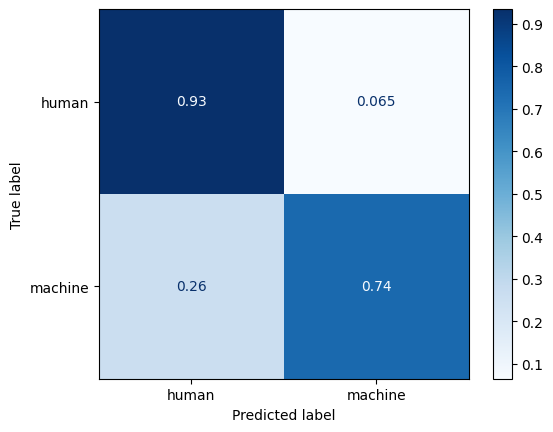

In [159]:
xgb_model = xgb.XGBRegressor(objective="binary:logistic")
xgb_model.fit(X_train, y_train)

pred_values = xgb_model.predict(X_train)
pred_labels = np.round(pred_values)
print('Train Report')
print('--------------------------------------------------------------')
print(classification_report(y_train, pred_labels, digits=3))

pred_values = xgb_model.predict(X_test)
pred_labels = np.round(pred_values)
print('Test Report')
print('--------------------------------------------------------------')
print(classification_report(y_test, pred_labels, digits=3))

conf_matrix = confusion_matrix(y_test, pred_labels)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
cm_display = ConfusionMatrixDisplay(conf_matrix, display_labels = ['human', 'machine'],)
cm_display.plot(cmap='Blues')
plt.show()

### Baseline

In [160]:
baseline_features = [
    'mcalpine_eflaw', 
    'dale_chall_readability_score', 
    'linsear_write_formula', 
    'coleman_liau_index',
    'smog_index'
]

In [161]:
df_filtered = df_all[baseline_features + ['LABEL']]
df_filtered.shape

(85450, 6)

In [162]:
X_filtered = df_filtered.drop('LABEL').to_numpy()
y_filtered = df_filtered['LABEL'].apply(lambda y: 0 if y == -1 else 1).to_numpy()
X_filtered.shape, y_filtered.shape

((85450, 5), (85450,))

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=447128, shuffle=True, stratify=y_filtered)

Train Report
--------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.917     0.925     0.921     46837
           1      0.834     0.819     0.826     21523

    accuracy                          0.892     68360
   macro avg      0.876     0.872     0.874     68360
weighted avg      0.891     0.892     0.891     68360

Test Report
--------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.898     0.906     0.902     11709
           1      0.792     0.777     0.785      5381

    accuracy                          0.866     17090
   macro avg      0.845     0.842     0.843     17090
weighted avg      0.865     0.866     0.865     17090



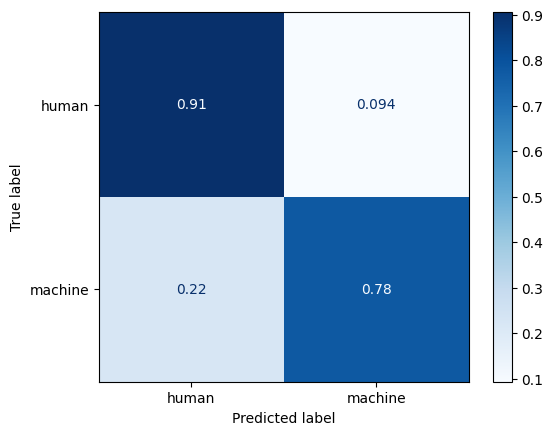

In [164]:
xgb_model = xgb.XGBRegressor(objective="binary:logistic")
xgb_model.fit(X_train, y_train)

pred_values = xgb_model.predict(X_train)
pred_labels = np.round(pred_values)
print('Train Report')
print('--------------------------------------------------------------')
print(classification_report(y_train, pred_labels, digits=3))

pred_values = xgb_model.predict(X_test)
pred_labels = np.round(pred_values)
print('Test Report')
print('--------------------------------------------------------------')
print(classification_report(y_test, pred_labels, digits=3))

conf_matrix = confusion_matrix(y_test, pred_labels)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
cm_display = ConfusionMatrixDisplay(conf_matrix, display_labels = ['human', 'machine'],)
cm_display.plot(cmap='Blues')
plt.show()

### Baseline + TD-IDF Cosine Similarity

In [165]:
baseline_features = [
    'mcalpine_eflaw', 
    'dale_chall_readability_score', 
    'linsear_write_formula', 
    'coleman_liau_index',
    'smog_index'
]

In [166]:
df_cosine = pl.read_csv('cosine_similarities_1k.csv')

df_filtered = df_all[:1000]

df_filtered = df_filtered[baseline_features + ['LABEL']]


df_filtered = df_filtered.with_columns([
    pl.Series(name="gpt_similarity", values=df_cosine['gpt_similarity']),
    pl.Series(name="human_similarity", values=df_cosine['human_similarity']),
])

df_filtered.columns, df_filtered.shape


(['mcalpine_eflaw',
  'dale_chall_readability_score',
  'linsear_write_formula',
  'coleman_liau_index',
  'smog_index',
  'LABEL',
  'gpt_similarity',
  'human_similarity'],
 (1000, 8))

In [167]:
X_filtered = df_filtered.drop('LABEL').to_numpy()
y_filtered = df_filtered['LABEL'].apply(lambda y: 0 if y == -1 else 1).to_numpy()
X_filtered.shape, y_filtered.shape

((1000, 7), (1000,))

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=447128, shuffle=True, stratify=y_filtered)

Train Report
--------------------------------------------------------------
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       552
           1      1.000     1.000     1.000       248

    accuracy                          1.000       800
   macro avg      1.000     1.000     1.000       800
weighted avg      1.000     1.000     1.000       800

Test Report
--------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.869     0.913     0.890       138
           1      0.782     0.694     0.735        62

    accuracy                          0.845       200
   macro avg      0.825     0.803     0.813       200
weighted avg      0.842     0.845     0.842       200



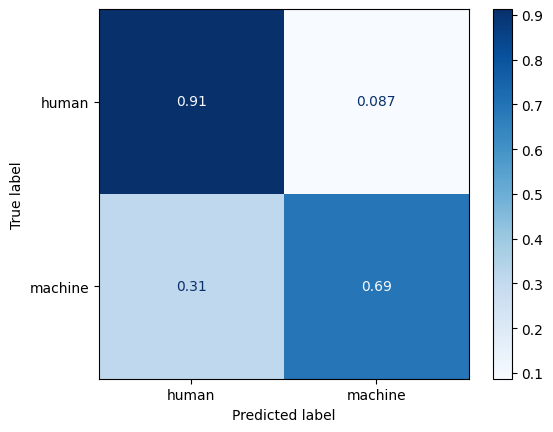

In [169]:
xgb_model = xgb.XGBRegressor(objective="binary:logistic")
xgb_model.fit(X_train, y_train)

pred_values = xgb_model.predict(X_train)
pred_labels = np.round(pred_values)
print('Train Report')
print('--------------------------------------------------------------')
print(classification_report(y_train, pred_labels, digits=3))

pred_values = xgb_model.predict(X_test)
pred_labels = np.round(pred_values)
print('Test Report')
print('--------------------------------------------------------------')
print(classification_report(y_test, pred_labels, digits=3))

conf_matrix = confusion_matrix(y_test, pred_labels)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
cm_display = ConfusionMatrixDisplay(conf_matrix, display_labels = ['human', 'machine'],)
cm_display.plot(cmap='Blues')
plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


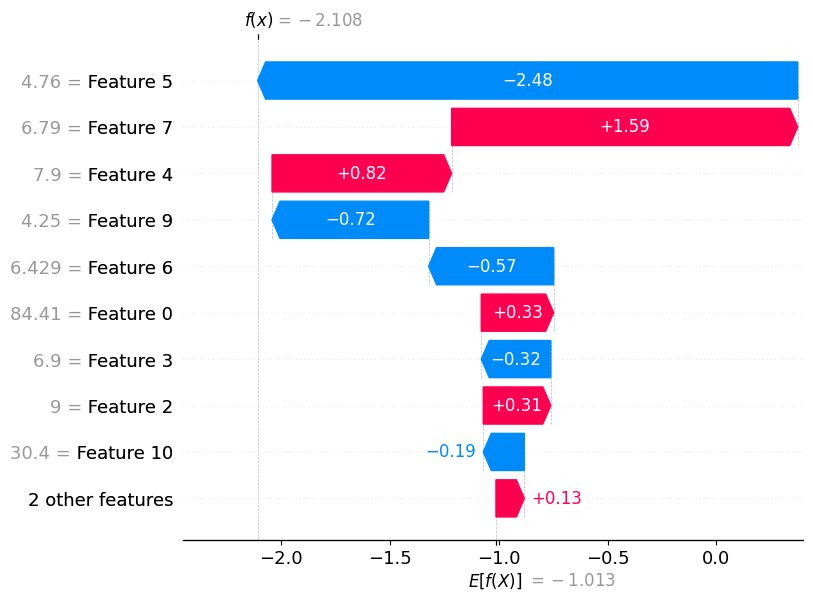

In [6]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


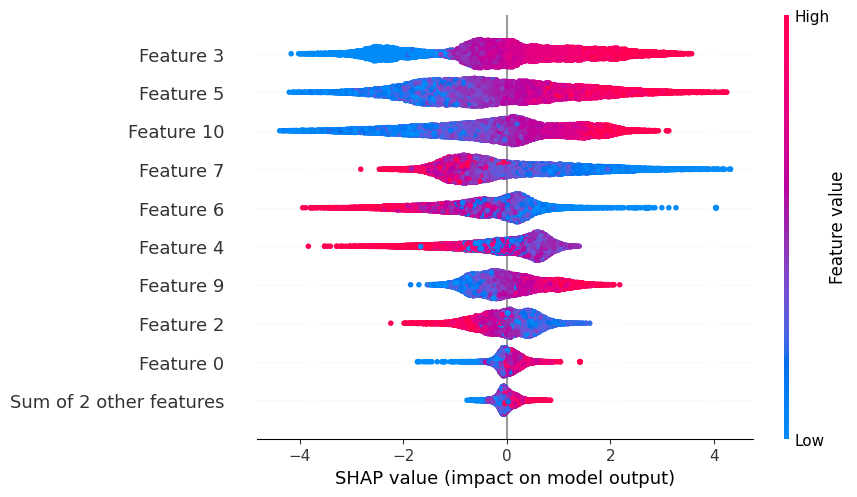

In [7]:
shap.plots.beeswarm(shap_values)

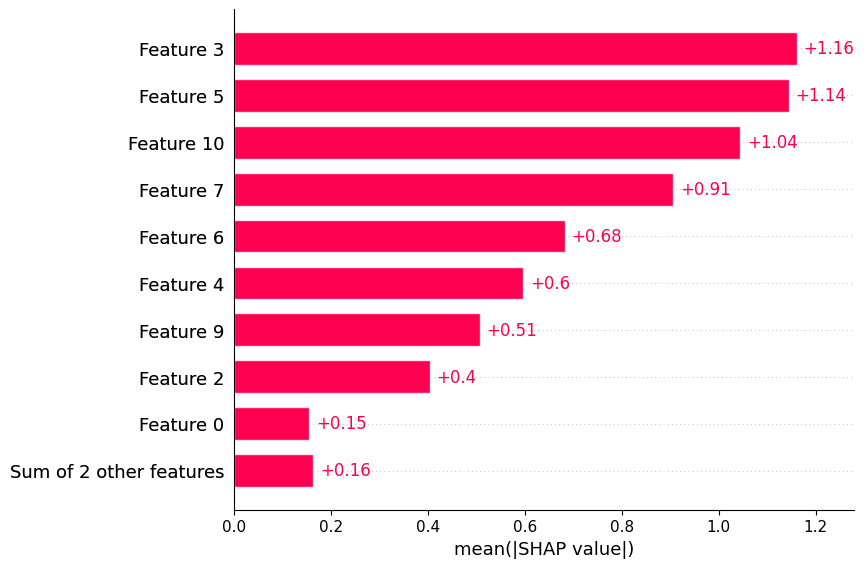

In [8]:
shap.plots.bar(shap_values)

Feature 3, 5, 10, 7, 6 are: `[
    'gunning_fog',
    'automated_readability_index',
    'spache_readability',
    'linsear_write_formula',
    'coleman_liau_index'
]`

In [14]:
top_features = [
    'gunning_fog',
    'automated_readability_index',
    'spache_readability',
    'linsear_write_formula',
    'coleman_liau_index'
]

In [19]:
print(shap_values.values.shape)
print(shap_values)

(28199, 11)
.values =
array([[ 0.33250958,  0.10904454,  0.31025624, ...,  0.02118053,
        -0.719334  , -0.18856938],
       [ 0.10567115, -0.04704872, -0.54788995, ...,  0.00161917,
        -0.5417664 , -0.01365508],
       [ 0.11647086,  0.3343711 , -0.6651655 , ..., -0.15706837,
         1.4000194 ,  1.6177943 ],
       ...,
       [ 0.06790547,  0.2999249 , -0.7701959 , ..., -0.03381944,
         0.49024865,  1.3187151 ],
       [-0.1144881 , -0.07714862,  0.5322136 , ..., -0.15030083,
        -0.4600732 , -0.13105968],
       [ 0.08801808, -0.04853041,  0.32240075, ..., -0.08332536,
        -0.37922895, -0.8388465 ]], dtype=float32)

.base_values =
array([-1.0130059, -1.0130059, -1.0130059, ..., -1.0130059, -1.0130059,
       -1.0130059], dtype=float32)

.data =
array([[84.41,  6.6 ,  9.  , ...,  7.  ,  4.25, 30.4 ],
       [77.06,  7.4 , 10.88, ...,  7.  ,  4.25, 28.5 ],
       [70.13, 14.2 , 17.2 , ..., 17.  ,  7.3 , 69.  ],
       ...,
       [69.15, 10.4 , 13.85, ...,  9. 

In [33]:
gunning_fog_shap = shap_values.values[:, 2]

In [34]:
prob_test = xgb_model.predict(X_test)
prob_test

array([1.0831584e-01, 1.8892447e-03, 3.2826708e-04, ..., 4.0794355e-03,
       3.4683752e-01, 1.9858319e-02], dtype=float32)

In [35]:
idxs_above_thresh = np.argwhere(prob_test >= 0.5)
idxs_below_thresh = np.argwhere(prob_test < 0.5)

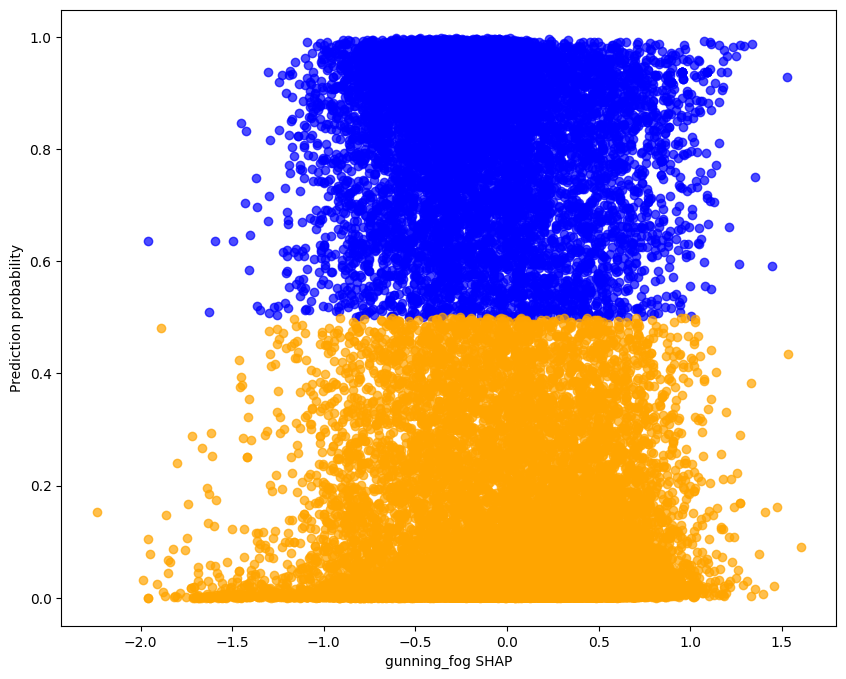

In [37]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(x=gunning_fog_shap[idxs_above_thresh], y=prob_test[idxs_above_thresh], alpha=0.7, color='blue')
ax.scatter(x=gunning_fog_shap[idxs_below_thresh], y=prob_test[idxs_below_thresh], alpha=0.7, color='orange')

plt.ylabel('Prediction probability')
plt.xlabel('gunning_fog SHAP')
plt.show()

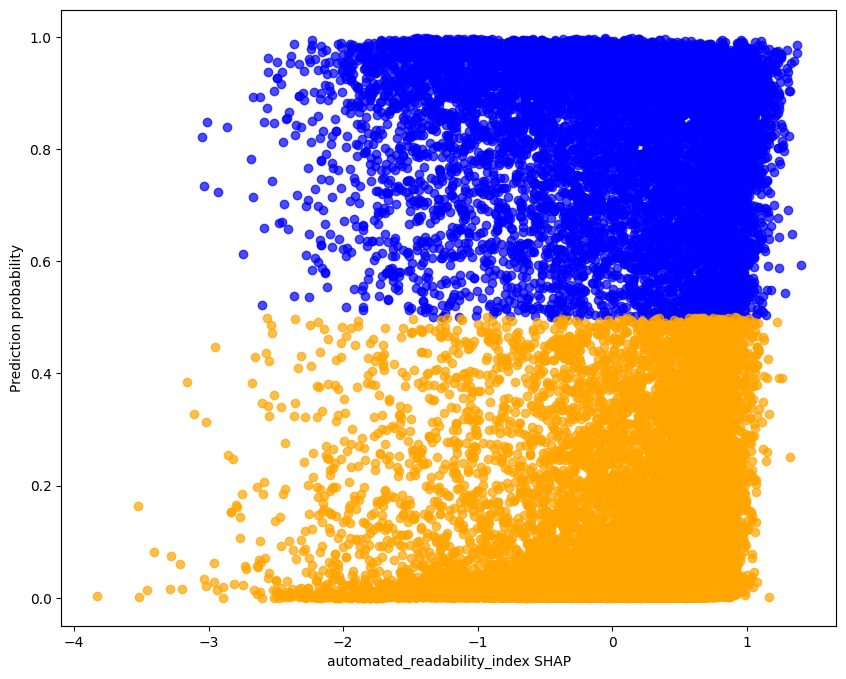

In [38]:
automated_readability_index_shap = shap_values.values[:, 4]
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(x=automated_readability_index_shap[idxs_above_thresh], y=prob_test[idxs_above_thresh], alpha=0.7, color='blue')
ax.scatter(x=automated_readability_index_shap[idxs_below_thresh], y=prob_test[idxs_below_thresh], alpha=0.7, color='orange')

plt.ylabel('Prediction probability')
plt.xlabel('automated_readability_index SHAP')
plt.show()

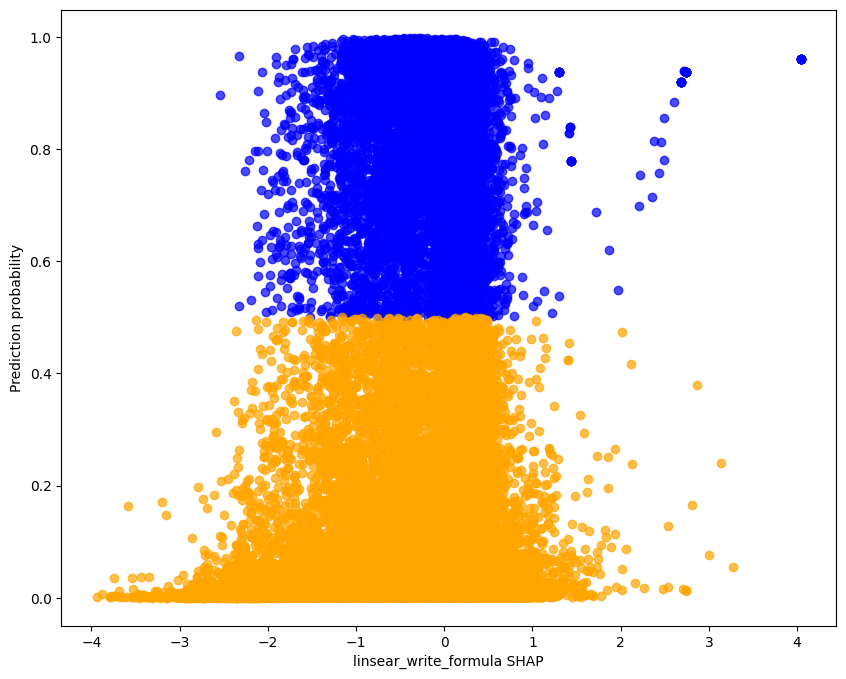

In [39]:
linsear_write_formula_shap = shap_values.values[:, 6]
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(x=linsear_write_formula_shap[idxs_above_thresh], y=prob_test[idxs_above_thresh], alpha=0.7, color='blue')
ax.scatter(x=linsear_write_formula_shap[idxs_below_thresh], y=prob_test[idxs_below_thresh], alpha=0.7, color='orange')

plt.ylabel('Prediction probability')
plt.xlabel('linsear_write_formula SHAP')
plt.show()

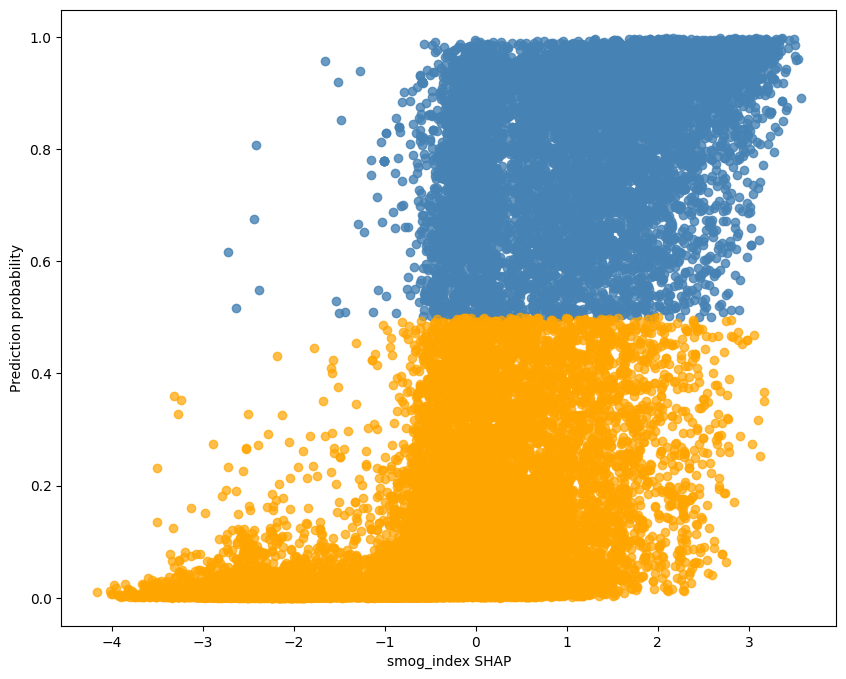

In [42]:
smog_index_shap = shap_values.values[:, 3]
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(x=smog_index_shap[idxs_above_thresh], y=prob_test[idxs_above_thresh], alpha=0.8, color='steelblue')
ax.scatter(x=smog_index_shap[idxs_below_thresh], y=prob_test[idxs_below_thresh], alpha=0.7, color='orange')

plt.ylabel('Prediction probability')
plt.xlabel('smog_index SHAP')
plt.show()

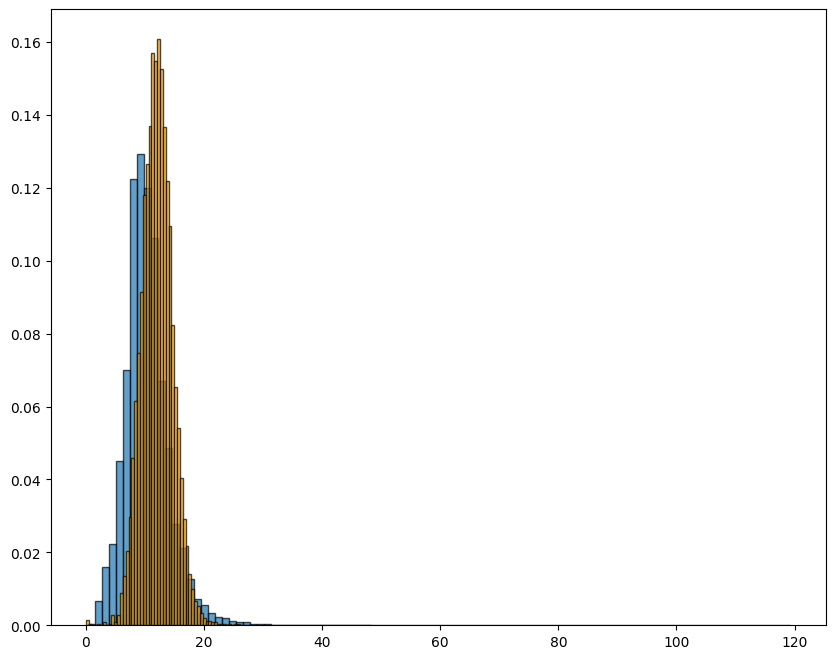

In [29]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(df_all.filter(pl.col('LABEL') == -1)['gunning_fog'], bins=100, edgecolor='black', density=True, alpha=0.7)
ax.hist(df_all.filter(pl.col('LABEL') == 1)['gunning_fog'], bins=100, edgecolor='black', density=True, color='orange', alpha=0.7)

plt.show()

In [11]:
shap.plots.scatter(shap_values[:,"Feature 5"], color=shap_values)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## 2. MLP

In [54]:
# Environment variables
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

N_EPOCHS = 300
LEARNING_RATE = 0.0005
DROPOUT_RATE = 0.3

In [55]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(20, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [56]:
def train_mlp(
        model: nn.Module, 
        dataloader_train: DataLoader, 
        criterion,
        optimizer: torch.optim.Optimizer,
        n_epochs: int,
        X_valid: torch.Tensor,
        y_valid: torch.Tensor):
    # Load validation set to device
    X_valid = X_valid.to(DEVICE)
    y_valid = y_valid.to(DEVICE)

    train_loss_history = []
    valid_loss_history = []

    start_time = time()
    for epoch in range(n_epochs):
        running_train_loss = 0.0
        # Batches
        for inputs, labels in tqdm(dataloader_train):
            model.train()
            # Copy batch to device
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # Rremove gradients from previous batch
            optimizer.zero_grad()
            # Predict using current model state
            outputs = model(inputs)

            # Compute batch loss
            loss = criterion(outputs, labels)
            # Backpropagate
            loss.backward()
            optimizer.step()

            # Add training loss
            running_train_loss += loss.item()
        # Epoch training loss (divide by num of batches)
        epoch_train_loss = running_train_loss / len(dataloader_train) 
        train_loss_history.append(epoch_train_loss)

        # Epoch validation loss
        with torch.inference_mode():
            outputs_valid = model(X_valid)
            epoch_valid_loss = criterion(outputs_valid, y_valid).item()
            # epoch_valid_loss = loss_valid.item() * X_valid.size(0)
            valid_loss_history.append(epoch_valid_loss)
        print(f"Epoch {epoch+1}/{n_epochs}: Train Loss = {epoch_train_loss:.4f}, Validation Loss = {epoch_valid_loss:.4f}")

    print(f"Took {time() - start_time:.2f} seconds to train in total")
    return train_loss_history, valid_loss_history

In [57]:
def predict(model_with_logit: nn.Module, X: torch.Tensor) -> torch.Tensor:
    was_training = model_with_logit.training
    model_with_logit.eval()
    with torch.inference_mode():
        # Predicted probabilities
        pred_probs = torch.sigmoid(model_with_logit(X.to(DEVICE)))
    # Predicted labels
    if was_training is True:
        model_with_logit.train()
    return torch.round(pred_probs)

def predict_probs(model_with_logit: nn.Module, X: torch.Tensor) -> torch.Tensor:
    was_training = model_with_logit.training
    model_with_logit.eval()
    with torch.inference_mode():
        # Predicted probabilities
        pred_probs = torch.sigmoid(model_with_logit(X.to(DEVICE)))
    # Predicted labels
    if was_training is True:
        model_with_logit.train()
    return pred_probs

In [58]:
def get_accuracy(model_with_logit: nn.Module, X: torch.Tensor, y: torch.Tensor):
    X = X.to(DEVICE)
    y = y.to(DEVICE)
    # Predict labels using model
    pred_labels = predict(model_with_logit, X).to('cpu')
    X = X.to('cpu')
    y = y.to('cpu')
    # Compare predicted with ground truth
    is_equal_tensor = torch.eq(pred_labels.squeeze(), y.squeeze())
    accuracy = is_equal_tensor.sum() / len(X)

    diff = (pred_labels.squeeze() - y.squeeze())
    fpos = diff[diff == -1].shape[0]
    fneg = diff[diff == 1].shape[0]
    
    return accuracy.item(), fpos, fneg

Train and test MLP model

In [62]:
 # Create training and validation tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train.reshape(-1, 1)).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test.reshape(-1, 1)).float()

# Create tensor dataset for training
dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
# torch.manual_seed(2298)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

# Create model
model = MLP().to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005) # lr=0.00005 seems best with Adam
# Train model
start = time()
train_loss_history, valid_loss_history = train_mlp(
    model, 
    dataloader_train, 
    criterion, 
    optimizer, 
    n_epochs=20, 
    X_valid=X_test_tensor, 
    y_valid=y_test_tensor
)

# Compute accuracy, false positives and false negatives
accuracy_train, fpos_train, fneg_train = get_accuracy(model, X_train_tensor, y_train_tensor)
accuracy_valid, fpos_valid, fneg_valid = get_accuracy(model, X_test_tensor, y_test_tensor)

print(f'Best Training Loss = {np.min(train_loss_history):.4f}')
print(f'Training Accuracy = {accuracy_train:.4f}')
print(f'Training False Positive = {fpos_train}')
print(f'Training False Negative = {fneg_train}')  

print(f'\nBest Test Loss = {np.min(valid_loss_history):.4f}')
print(f'Test Accuracy = {accuracy_valid:.4f}')
print(f'Test False Positive = {fpos_valid}')
print(f'Test False Negative = {fneg_valid}')


100%|██████████| 1790/1790 [00:07<00:00, 240.12it/s]


Epoch 1/20: Train Loss = 4.8669, Validation Loss = 0.7831


100%|██████████| 1790/1790 [00:06<00:00, 262.70it/s]


Epoch 2/20: Train Loss = 0.8089, Validation Loss = 1.0413


100%|██████████| 1790/1790 [00:06<00:00, 261.20it/s]


Epoch 3/20: Train Loss = 0.7304, Validation Loss = 0.7306


100%|██████████| 1790/1790 [00:06<00:00, 260.19it/s]


Epoch 4/20: Train Loss = 0.6670, Validation Loss = 0.6594


100%|██████████| 1790/1790 [00:06<00:00, 256.77it/s]


Epoch 5/20: Train Loss = 0.6421, Validation Loss = 0.6453


100%|██████████| 1790/1790 [00:06<00:00, 256.44it/s]


Epoch 6/20: Train Loss = 0.6071, Validation Loss = 0.5979


100%|██████████| 1790/1790 [00:06<00:00, 264.06it/s]


Epoch 7/20: Train Loss = 0.5918, Validation Loss = 0.5753


100%|██████████| 1790/1790 [00:06<00:00, 265.46it/s]


Epoch 8/20: Train Loss = 0.5817, Validation Loss = 0.5662


100%|██████████| 1790/1790 [00:06<00:00, 265.62it/s]


Epoch 9/20: Train Loss = 0.5798, Validation Loss = 0.5666


100%|██████████| 1790/1790 [00:06<00:00, 270.81it/s]


Epoch 10/20: Train Loss = 0.5757, Validation Loss = 0.5818


100%|██████████| 1790/1790 [00:06<00:00, 272.96it/s]


Epoch 11/20: Train Loss = 0.5727, Validation Loss = 0.5879


100%|██████████| 1790/1790 [00:06<00:00, 270.77it/s]


Epoch 12/20: Train Loss = 0.5746, Validation Loss = 0.5638


100%|██████████| 1790/1790 [00:06<00:00, 271.88it/s]


Epoch 13/20: Train Loss = 0.5709, Validation Loss = 0.5616


100%|██████████| 1790/1790 [00:06<00:00, 272.56it/s]


Epoch 14/20: Train Loss = 0.5746, Validation Loss = 0.5628


100%|██████████| 1790/1790 [00:06<00:00, 279.06it/s]


Epoch 15/20: Train Loss = 0.5746, Validation Loss = 0.5663


100%|██████████| 1790/1790 [00:06<00:00, 272.88it/s]


Epoch 16/20: Train Loss = 0.5762, Validation Loss = 0.6262


100%|██████████| 1790/1790 [00:06<00:00, 275.22it/s]


Epoch 17/20: Train Loss = 0.5752, Validation Loss = 0.5746


100%|██████████| 1790/1790 [00:06<00:00, 271.73it/s]


Epoch 18/20: Train Loss = 0.5708, Validation Loss = 0.5643


100%|██████████| 1790/1790 [00:06<00:00, 267.25it/s]


Epoch 19/20: Train Loss = 0.5719, Validation Loss = 0.5650


100%|██████████| 1790/1790 [00:06<00:00, 273.57it/s]


Epoch 20/20: Train Loss = 0.5762, Validation Loss = 0.5691
Took 135.24 seconds to train in total
Best Training Loss = 0.5708
Training Accuracy = 0.6913
Training False Positive = 17095
Training False Negative = 577

Best Test Loss = 0.5616
Test Accuracy = 0.6912
Test False Positive = 8418
Test False Negative = 289
